<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/KneeOsteoarthritisCNN/blob/main/KneeOsteoarthritisCNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/veri.zip"  -d  "/content/Image_Folder3"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from distutils.dir_util import copy_tree
import os 
def createTrainFolder(dirs):
  for dir in dirs:
    try:
      os.makedirs("/content/train/0/")
      os.makedirs("/content/train/1/")
      os.makedirs("/content/train/2/")
      os.makedirs("/content/train/3/")
      os.makedirs("/content/train/4/")
    except:
      pass

    copy_tree(dir+"/0/","/content/train/0/")
    copy_tree(dir+"/1/","/content/train/1/")
    copy_tree(dir+"/2/","/content/train/2/")
    copy_tree(dir+"/3/","/content/train/3/")
    copy_tree(dir+"/4/","/content/train/4/")

def createValFolder(dirs):
  for dir in dirs:
    try:
      os.makedirs("/content/val/0/")
      os.makedirs("/content/val/1/")
      os.makedirs("/content/val/2/")
      os.makedirs("/content/val/3/")
      os.makedirs("/content/val/4/")
    except:
      pass

    copy_tree(dir+"/0/","/content/val/0/")
    copy_tree(dir+"/1/","/content/val/1/")
    copy_tree(dir+"/2/","/content/val/2/")
    copy_tree(dir+"/3/","/content/val/3/")
    copy_tree(dir+"/4/","/content/val/4/")


dirs = ["/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/train","/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/test"]
createTrainFolder(dirs)
createValFolder(["/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/val"])


In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
import numpy as np
import cv2
def toGrayScale(img):
  img = np.array(img) 
  if(len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  clahe = cv2.createCLAHE(clipLimit = 5)
  final_img = clahe.apply(img) 
  

  
  
  return final_img


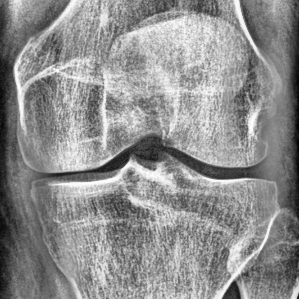

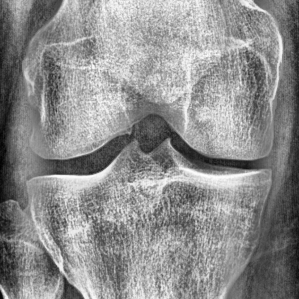

In [ ]:
img = cv2.imread("/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL299/val/0/9230504L.png")
img2 = cv2.imread("/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL299/val/0/9272393R.png")
from google.colab.patches import cv2_imshow


cv2_imshow(toGrayScale(img))
cv2_imshow(toGrayScale(img2))


In [ ]:
from torchvision import datasets, transforms as T

transformfunc = T.Compose([toGrayScale, T.ToTensor(),T.RandomRotation(degrees=(-3,3), fill=(0,)),T.Resize(224),T.RandomHorizontalFlip(p=0.1)])

In [ ]:
import torch
import torchvision.datasets as datasets

train_set = datasets.ImageFolder("/content/train",transform=transformfunc)
val_set = datasets.ImageFolder("/content/val",transform=transformfunc)

In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=train_set,batch_size=32,shuffle=True)
valloader = DataLoader(dataset=val_set,batch_size=1,shuffle=False)

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',[0,1,2,3,4],train_set.targets )
class_weights

array([0.50830769, 1.10789866, 0.75741212, 1.51714286, 6.6375    ])

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 7434
    Root location: /content/train
    StandardTransform
Transform: Compose(
               <function toGrayScale at 0x7fe5b3542830>
               ToTensor()
               RandomRotation(degrees=[-3.0, 3.0], interpolation=nearest, expand=False, fill=(0,))
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.1)
           )

In [ ]:
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,Dropout,Sigmoid,BatchNorm2d

class Net(nn.Module):
  def __init__(self):
     super(Net, self).__init__()
     self.cnn_layers = Sequential(
     Conv2d(1,32, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(32),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(32,64, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(64),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(64,128, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(128),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(128,256, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(256),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2)
     )
     self.linear_layers = Sequential( 
        Linear(50176,150),
        Dropout(0.1),
        Linear(150,5)
        )
     #Defining the forward pass
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)

    return x

model = Net()
model = model.to(device)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

optimizer = torch.optim.Adam(model.parameters())


def train(model,criterion,train_loader,optimizer,epochs = 10):
  train_loss = []
  accuracy_list = [0]
  f1_list = []
  loss_list = []
  for epoch in range(epochs):
    running_loss = 0.0
    for i,(x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device) # Modele girecek tensorları cudaya gönder
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z,y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 50 == 49 :
        preds = []
        actuals = []
        for x,y in valloader:
          x,y = x.to(device),y.to(device).to(torch.float32)
          z = model(x)
          label = torch.max(z,-1).indices.item()
          preds.append(label)
          actuals.append(y.item())
        score = f1_score(actuals,preds, average='macro')
        accuracy = accuracy_score(actuals,preds)
        print("F1 score :",score)
        print("Accuracy :",accuracy)
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
        if accuracy > max(accuracy_list) :
          torch.save(model, "best_model")
        accuracy_list.append(accuracy)
        f1_list.append(score)
        loss_list.append(running_loss / 50)




train(model,criterion,trainloader,optimizer,15)

F1 score : 0.18602372560217995
Accuracy : 0.3171912832929782
[1,    50] loss: 15.055
F1 score : 0.0874070498800887
Accuracy : 0.16101694915254236
[1,   100] loss: 18.559
F1 score : 0.11498917058474127
Accuracy : 0.15617433414043583
[1,   150] loss: 21.957
F1 score : 0.1250427582234024
Accuracy : 0.24939467312348668
[1,   200] loss: 24.181
F1 score : 0.19773175348491034
Accuracy : 0.2542372881355932
[2,    50] loss: 1.881
F1 score : 0.16681901098925359
Accuracy : 0.19854721549636803
[2,   100] loss: 3.995
F1 score : 0.13678148478396074
Accuracy : 0.21912832929782083
[2,   150] loss: 5.740
F1 score : 0.29739345571838605
Accuracy : 0.43825665859564167
[2,   200] loss: 7.189
F1 score : 0.3821085076435084
Accuracy : 0.4552058111380145
[3,    50] loss: 1.468
F1 score : 0.3982952685552331
Accuracy : 0.4067796610169492
[3,   100] loss: 2.797
F1 score : 0.42743003342649366
Accuracy : 0.41404358353510895
[3,   150] loss: 4.025
F1 score : 0.4515134551054156
Accuracy : 0.437046004842615
[3,   200]

In [ ]:
model = torch.load("best_model")

In [ ]:
from sklearn.metrics import confusion_matrix

preds = []
actuals = []




""
for x,y in valloader:
  x,y = x.to(device),y.to(device).to(torch.float32)
  z = model(x)
  label = torch.max(z,-1).indices.item()
  preds.append(label)
  actuals.append(y.item())
matrix = confusion_matrix(actuals,preds)
matrix

array([[247,  43,  30,   8,   0],
       [ 88,  33,  25,   7,   0],
       [ 62,  22, 106,  22,   0],
       [  4,   8,  16,  73,   5],
       [  0,   0,   0,  10,  17]])

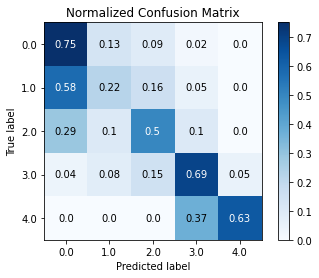

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(actuals, preds,normalize=True)

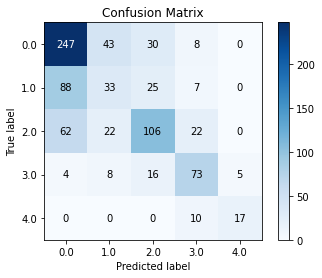

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(actuals, preds,normalize=False)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(actuals,preds, target_names=["Category 1","Category 2","Category 3","Category 4","Category 5"]))

              precision    recall  f1-score   support

  Category 1       0.62      0.75      0.68       328
  Category 2       0.31      0.22      0.25       153
  Category 3       0.60      0.50      0.54       212
  Category 4       0.61      0.69      0.65       106
  Category 5       0.77      0.63      0.69        27

    accuracy                           0.58       826
   macro avg       0.58      0.56      0.56       826
weighted avg       0.56      0.58      0.56       826



In [151]:
def test_class_probabilities(model, test_loader, n_class):
  model.eval()
  actuals = []
  probabilities = []
  with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device),y.to(device)
        outputs = model(x).squeeze()
        sm = torch.nn.Softmax()
        probability = sm(outputs) 
        probabilities.append(probability.tolist())
  return probabilities  


probabilities = test_class_probabilities(model,valloader,5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


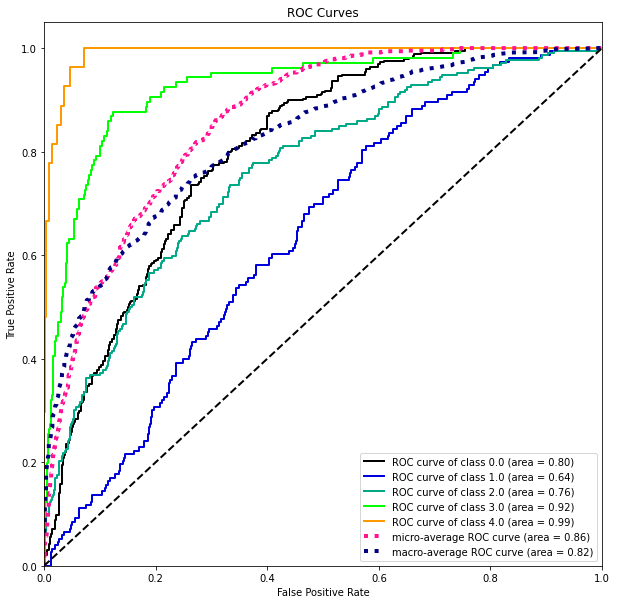

In [156]:
import scikitplot as skplt


skplt.metrics.plot_roc(actuals, probabilities,figsize=(10,10))